In [72]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

In [89]:
not 1

False

### adding SG with 1 maximum minutes of delay

In [73]:
tstamp = '1014-163557'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
create_field_from_state_item(state, 4, 'delay')
create_field_from_state_item(state, 1, 'n_requests')

### validate parameters

In [74]:
# sns.histplot(state, x='n_requests', hue='scenario')

In [75]:
## expected number of requests at stop 1 and 3 based on inputs
request_rates = [sum(OD_MATRIX[2]), sum(OD_MATRIX[4])]
expected_requests_per_trip = [rr/(60/SCHEDULE_HEADWAY) for rr in request_rates]

## actual requests per trip
total_trip_stops = trips[(trips['stop'].isin(CONTROL_STOPS)) & (trips['scenario']=='DN')].groupby(['direction', 'stop']).size().reset_index().rename(columns={0:'n_trips'})
total_requests = pax[(pax['boarding_time'].isna()) & (pax['scenario']=='DN')].groupby(['direction', 'origin']).size().reset_index().rename(columns={0:'n_requests'})
total_requests['stop'] = total_requests['origin'] - 1
actuals = total_trip_stops.merge(total_requests, on=['direction', 'stop'], how='left')
actuals['requests_per_trip'] = (actuals['n_requests']/actuals['n_trips']).round(2)

In [76]:
def get_n_trips_over_time(data, stop=0, direction='out', scenario='DN'):
    all_trips = data[(data['stop']==stop) & (data['direction']==direction) & (data['scenario']==scenario)].copy()
    all_trips = all_trips.sort_values('arrival_time').reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = all_trips[all_trips['arrival_time']-all_trips['scheduled_time']<(SCHEDULE_TOLERANCE/60)].copy().drop(columns=['count'])

    all_trips = all_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    on_time_trips = on_time_trips.reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = on_time_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    return all_trips, on_time_trips

In [77]:
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='DN')
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='FG')

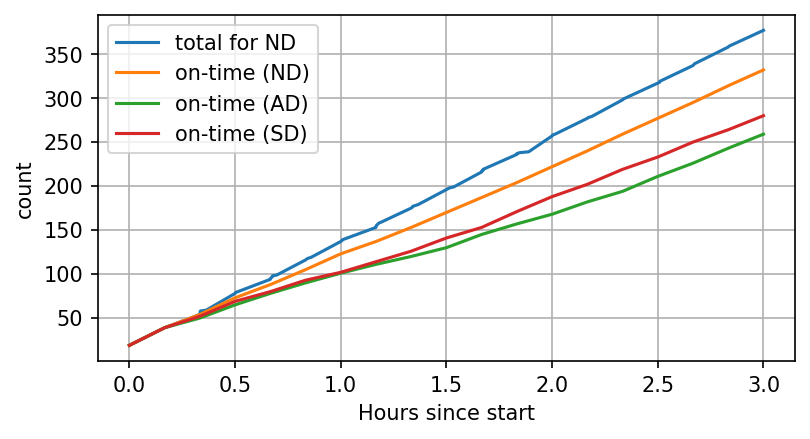

In [79]:
scenarios = ['ND', 'AD', 'SD']
fig, axs = plt.subplots(figsize=(6,3))
for i in range(len(scenarios)):
    all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario=scenarios[i])
    all_trips['arrival_time'] = all_trips['arrival_time']/60/60
    on_time_trips['arrival_time'] = on_time_trips['arrival_time']/60/60
    if scenarios[i] == 'ND':
        sns.lineplot(data=all_trips, x='arrival_time', y='count', ax=axs, label='total for ND')
    sns.lineplot(data=on_time_trips, x='arrival_time', y='count', ax=axs, label=f'on-time ({scenarios[i]})')
    axs.set_xlabel('Hours since start')
    axs.grid(True)

In [24]:
actuals

,direction,stop,n_trips,origin,n_requests,requests_per_trip
0,in,1,340,2,264,0.78
1,in,3,340,4,141,0.41
2,out,1,360,2,304,0.84
3,out,3,360,4,125,0.35


In [6]:
trips.drop_duplicates(subset=['direction', 'trip_id']).shape

(37, 14)

In [7]:
state[state['delay']<=0].groupby(['scenario']).size()

scenario
DN    555
FG    410
SG    496
dtype: int64

In [8]:
state.groupby(['scenario'])['action'].sum()

scenario
DN    599
FG      0
SG     89
Name: action, dtype: int64

In [81]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='ND', flex_stops=FLEX_STOPS)

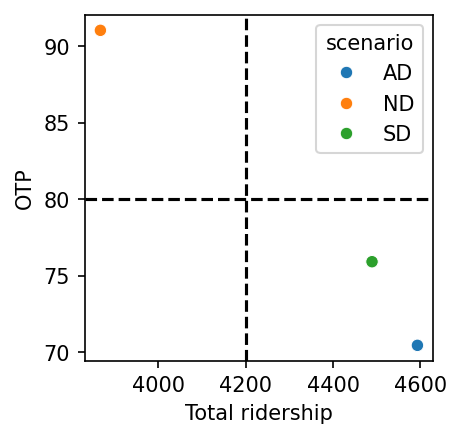

In [83]:
fig, axs = plt.subplots(figsize=(3,3))
sns.scatterplot(data=table, x='tot_ridership', y='otp', hue='scenario', ax=axs)
axs.set_xlabel('Total ridership')
axs.set_ylabel('OTP')
axs.axhline(y=80, color='black', linestyle='--')
axs.axvline(x=4200, color='black', linestyle='--')

In [19]:
table

,n_lates,idle_time,wait_time,headway_cv,load,denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips,avg_delay,otp
scenario,,,,,,,,,,,,
DN,86,15.45,304.0,0.117,2.22,811,3860,834,4694,739,-37.0,88.362652
FG,247,8.37,314.0,0.225,2.89,114,3867,878,4745,732,6.0,66.256831
SG,169,10.13,311.0,0.112,2.77,187,3839,863,4702,735,-19.0,77.006803


In [9]:
table_pcts

,n_lates,idle_time,wait_time,headway_cv,load,denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips,avg_delay
scenario,,,,,,,,,,,
DN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.000,-0.000
FG,182.759,-41.346,-0.641,54.701,32.877,-88.848,2.825,NaN,22.761,-0.680,-105.556
SG,94.253,-32.967,-1.282,6.838,27.397,-74.182,3.918,NaN,21.322,0.136,-52.778


<AxesSubplot: xlabel='idle_time', ylabel='Count'>

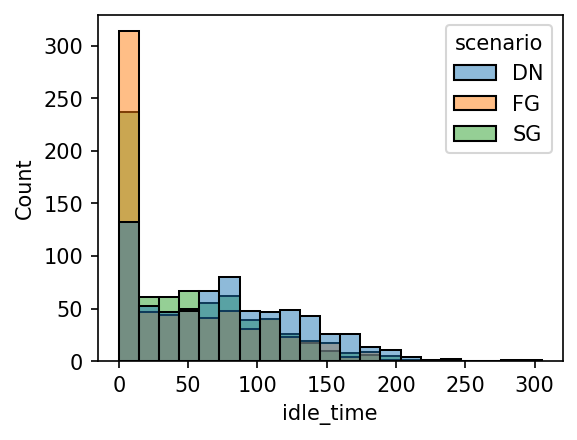

In [15]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

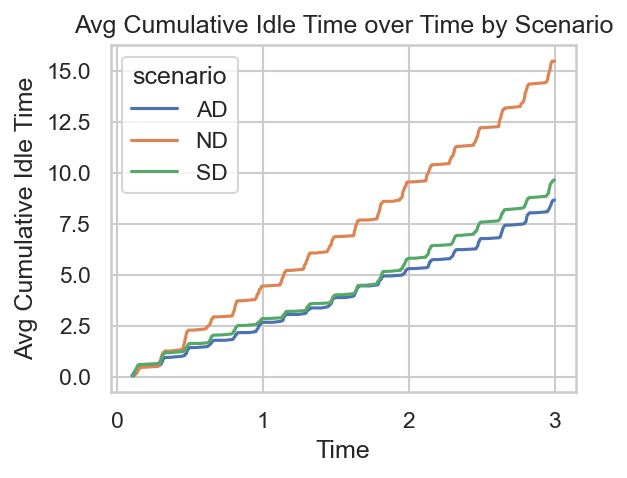

In [87]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [2]:
event.timestamps[-1]

284.0

In [11]:
pax.groupby(['origin', 'destination']).size().reset_index()

,origin,destination,0
0,0,1,847
1,0,3,1826
2,0,5,1776
3,1,3,856
4,1,5,841
5,1,6,1823
6,2,5,460
7,2,6,464
8,3,5,860
9,3,6,1808


In [15]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])

[('in', 0, 1, 6164.0)]
[('in', 2, 3, 157.0), ('in', 2, 3, 426.0), ('in', 2, 5, 1115.0), ('in', 2, 6, 1444.0), ('in', 2, 3, 1701.0), ('in', 2, 6, 2410.0), ('in', 2, 6, 2869.0), ('in', 2, 3, 3366.0)]
[('in', 3, 6, 5696.0)]
[('in', 4, 6, 280.0), ('in', 4, 5, 1974.0), ('in', 4, 6, 2670.0), ('in', 4, 6, 4121.0), ('in', 4, 6, 4718.0), ('in', 4, 5, 5348.0), ('in', 4, 6, 5610.0), ('in', 4, 6, 5662.0)]
[('in', 5, 6, 5756.0), ('in', 5, 6, 5878.0), ('in', 5, 6, 6040.0)]
[('out', 0, 1, 6008.0)]
[('out', 2, 3, 202.0), ('out', 2, 5, 893.0), ('out', 2, 6, 3028.0), ('out', 2, 6, 3718.0), ('out', 2, 3, 5718.0), ('out', 2, 6, 5863.0)]
[('out', 4, 6, 139.0), ('out', 4, 6, 1168.0), ('out', 4, 6, 2023.0), ('out', 4, 6, 2190.0), ('out', 4, 6, 2901.0), ('out', 4, 5, 3079.0), ('out', 4, 5, 3605.0), ('out', 4, 5, 4359.0), ('out', 4, 6, 4575.0), ('out', 4, 6, 5305.0), ('out', 4, 6, 5748.0)]
